# IMA204 Practical Session - Segmentation of medical images

**By**
- **Haithem DAGHMOURA**
- **Kais ZAIRI**




# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas.
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results.

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle).

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.**

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  C:\Users\DELL\Desktop\document_Haithem\3_rd_year_studies\ima204\tp4


In [6]:
def my_kmeans(image,k):
    #k = number of clusters

    # Reshaping the image
    pixel_vals = image.reshape((-1,1))

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria ( type, max_iter, epsilon )  type= 3 => number of iteration or accuracy stopping cond will be checked
    retval, labels, centers = cv2.kmeans(pixel_vals, k,
                None, criteria, 10, cv2.KMEANS_PP_CENTERS)  # kmeans++ version is used,
    # centers are the gray values that define the clusters

    centers = np.uint8(centers) # convert data into 8-bit values

    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value) # flatten() did nothing here
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions

    return segmented_image,segmented_labels ## segmented_image contains the gray levels of the center classes, segmented_labels contains the index of the center class


def my_colormap_white_bkg(Colormap_name,numLabels): # return a color map with bkg color is white (0 value)
    #numLabels = number of colors

    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor.

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  C:\Users\DELL\Desktop\document_Haithem\3_rd_year_studies\ima204\tp4/data/abdominalCT\CTs4.tiff
[  0 127]
There is no tumor


Text(0.5, 1.0, 'Image +contour tumor')

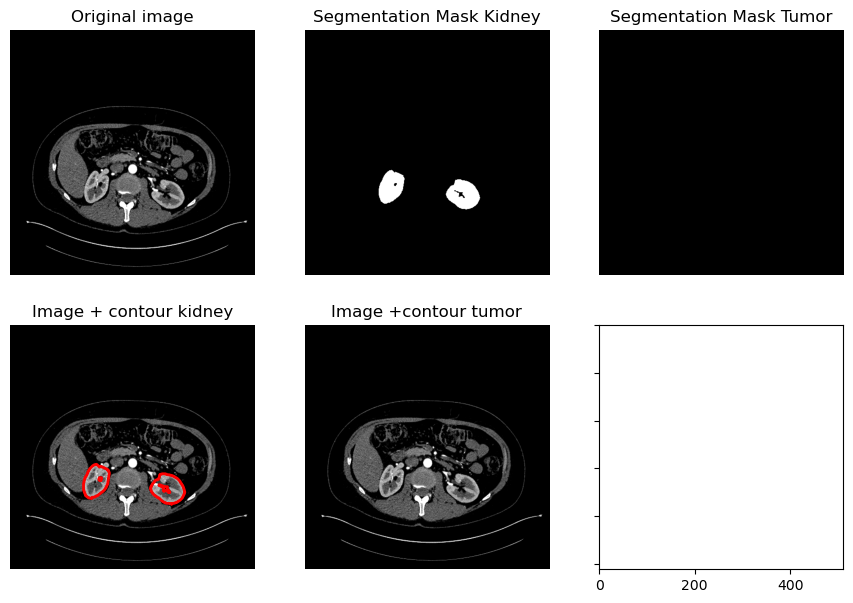

In [7]:
abdominalCT_path = Working_directory + '/data/abdominalCT'
os.listdir(abdominalCT_path)# return the names of the files in the path provided
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff') # gets a list of paths of the files that ends with -seg.tiff
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=3 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm] # get the path of the example to study
Labels_abdo_ex   = imread(filename_Segmentation) # read the image
filename         = filename_Segmentation[:-9] + '.tiff' # get the observed image name without labels
Img_abdo_ex      = imread(filename)  # read the observed image

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape: # handling uncoorespending the
  raise NameError('image and mask should have the same shape, problem...')

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['C:\\Users\\DELL\\Desktop\\document_Haithem\\3_rd_year_studies\\ima204\\tp4/data/brainMRI\\MRIs1-seg.png', 'C:\\Users\\DELL\\Desktop\\document_Haithem\\3_rd_year_studies\\ima204\\tp4/data/brainMRI\\MRIs2-seg.png', 'C:\\Users\\DELL\\Desktop\\document_Haithem\\3_rd_year_studies\\ima204\\tp4/data/brainMRI\\MRIs3-seg.png', 'C:\\Users\\DELL\\Desktop\\document_Haithem\\3_rd_year_studies\\ima204\\tp4/data/brainMRI\\MRIs4-seg.png']
Reading image  C:\Users\DELL\Desktop\document_Haithem\3_rd_year_studies\ima204\tp4/data/brainMRI\MRIs1.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

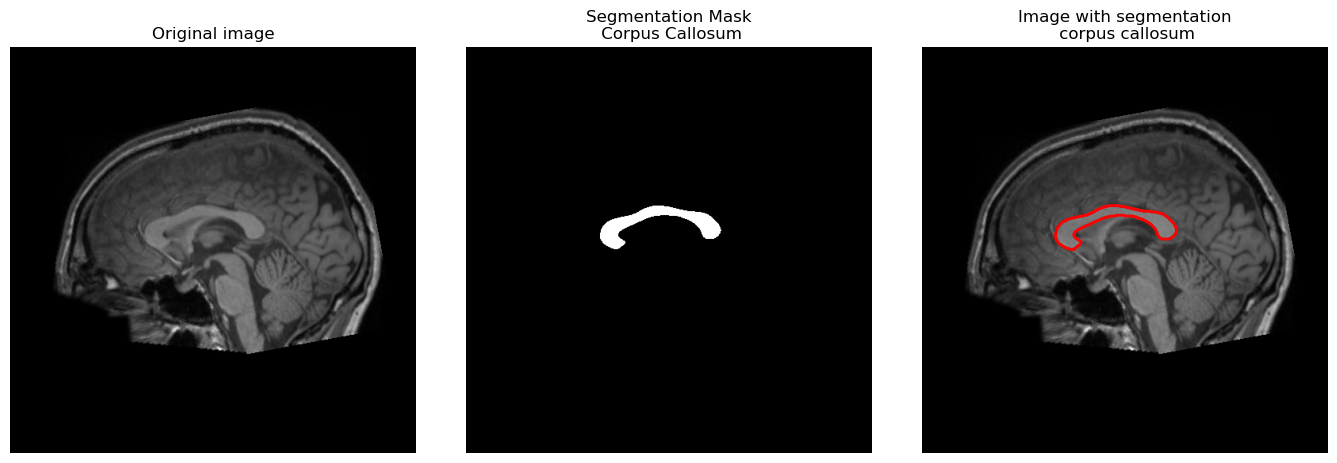

In [8]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 0 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI

The last section is about MRI sequences of the heart.
You are provided with **a single use case**.
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br>

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


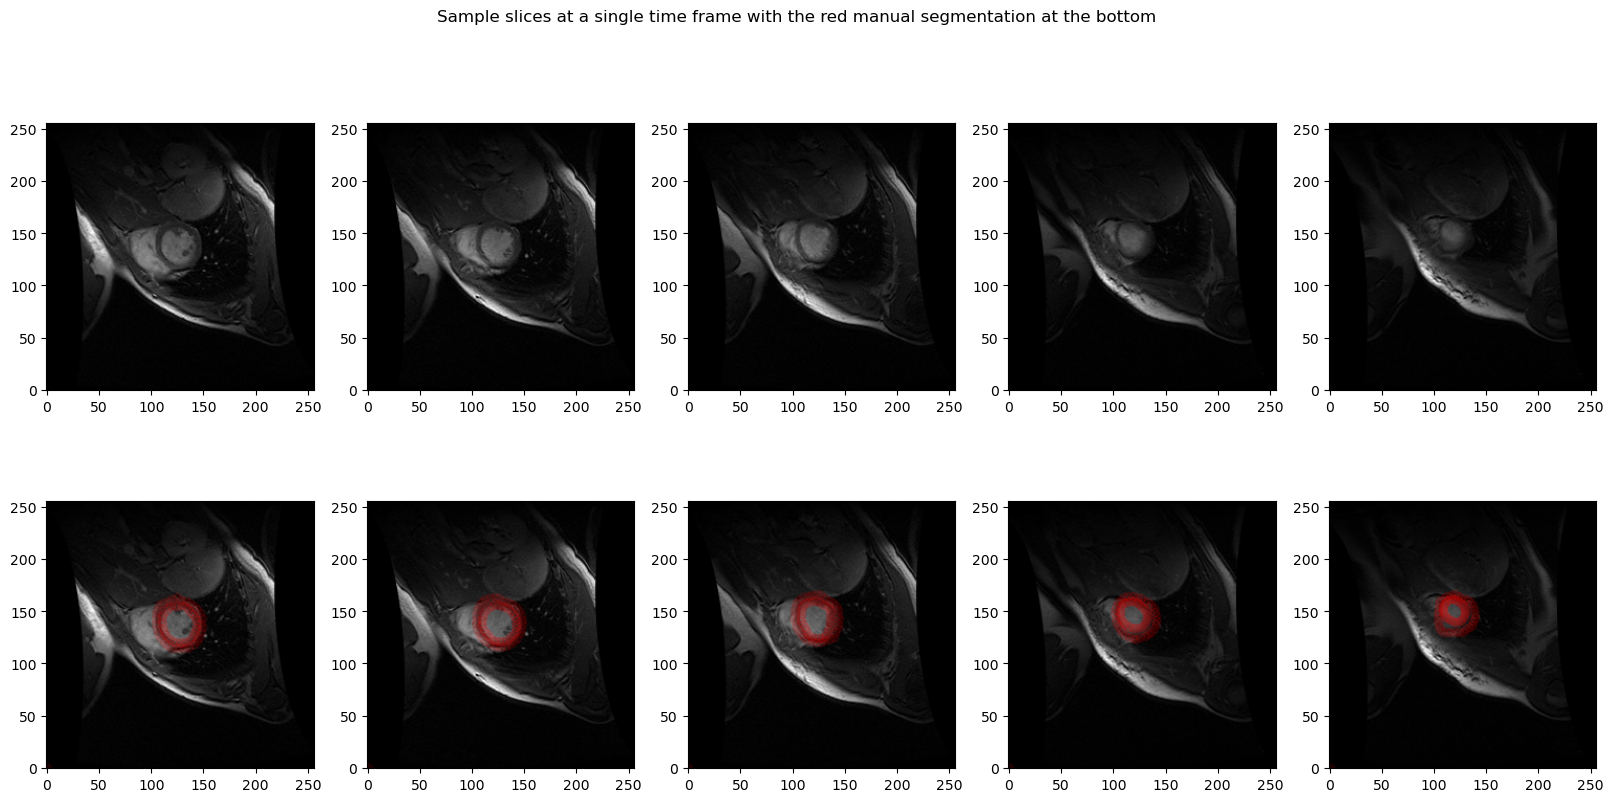

In [9]:

# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3],
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1);

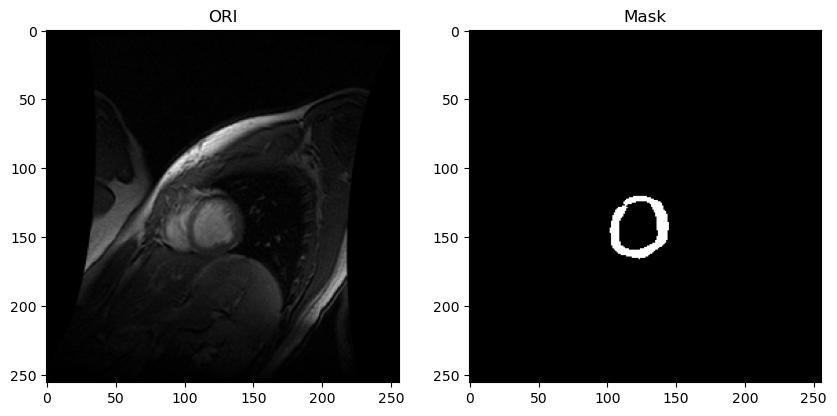

In [10]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images.


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



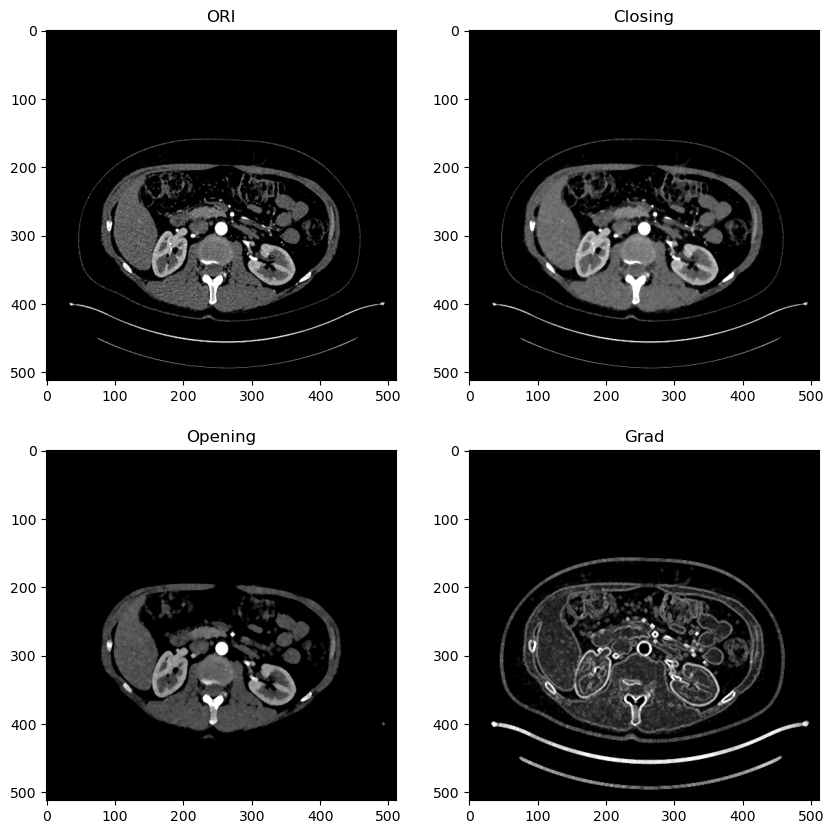

In [11]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

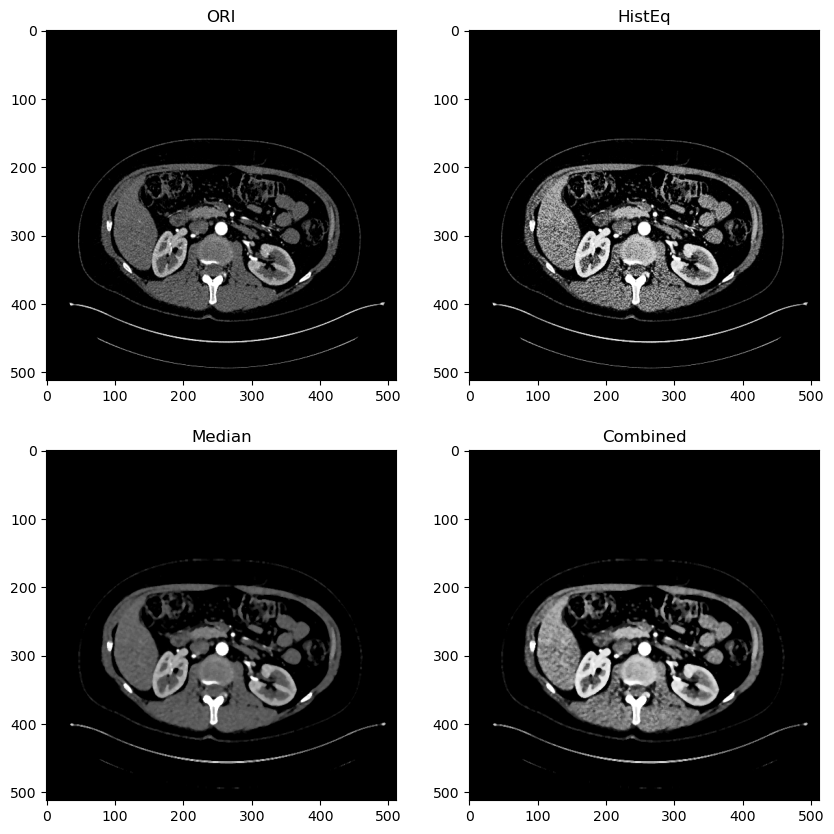

In [12]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question**
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest.


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).





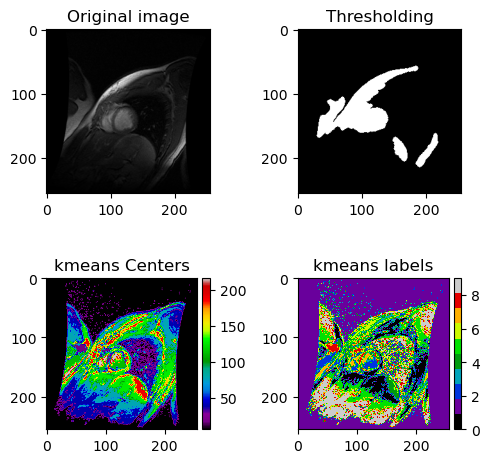

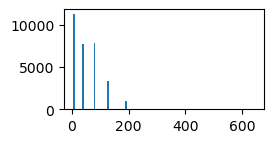

Your Target_value =  180
Distance of your Target_value to Centers =  [ 53 173 187 464  11 101 657 293  93 141]
Your selected label (starting with 0)=  4


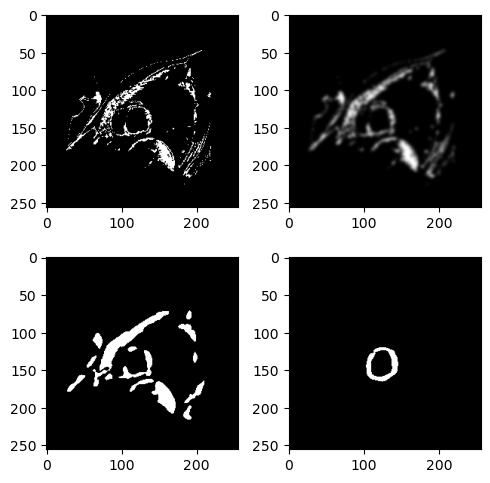

In [13]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
# Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
# nber_clusters     = 10; Target_value_thresh = 50 # For brain image


# [1] Example of segmentation via simple threshold
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh,
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(),
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, np.uint8(Img_seg_gt)) #####
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2,
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases.

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)




Max value in labels =  8
Number of connected components =  9


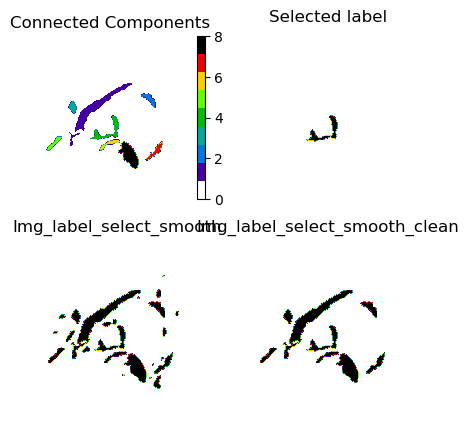

In [14]:
Img_label_select_filter = gaussian(Img_label_select, 2,
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==4

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');



# Pipeline K-means

Pipe description:

First, we obtained prior information from the target. Then, after running the kmeans algorithm on the image, we select the labels with reference to the prior information. Finally, we post-process the segmentation mask and decompose it into connected components, then return the best components based on the dice coefficients.

In [15]:
from sklearn.mixture import GaussianMixture

def dice(seg, gt):
    """A metric to evaluate the segmentation"""
    return np.sum(seg*gt)*2.0/(np.sum(seg)+np.sum(gt))



# We can expand our segmentation by Gaussian Mixture Model that can give better results

def my_gmm(image, k):
    # Reshape the image
    pixel_vals = image.reshape((-1, 1))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(pixel_vals)

    # Predict the cluster labels
    labels = gmm.predict(pixel_vals)

    # Get the cluster centers
    centers = gmm.means_.squeeze().astype(np.uint8)

    # Map labels to center points to obtain segmented data
    segmented_data = centers[labels.flatten()]

    # Reshape segmented data back into original image dimensions
    segmented_image = segmented_data.reshape(image.shape)

    return segmented_image, labels.reshape(image.shape)


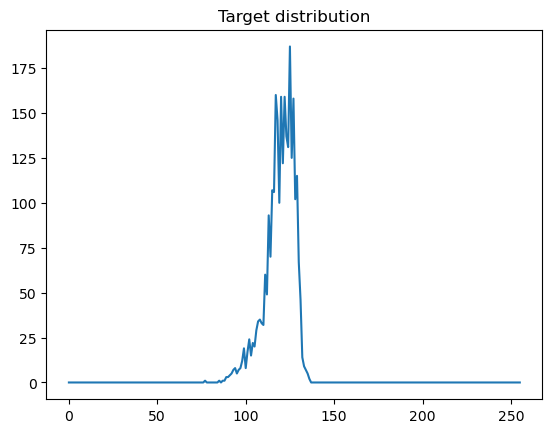

In [16]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10;                 # For abdo image

# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10                 # For cardiac image
#Img_brain_ex = (Img_brain_ex-Img_brain_ex.min())/(Img_brain_ex.max()-Img_brain_ex.min())
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10;                # For brain image

# Convert to binary mask
Img_seg_gt = np.uint8(Img_seg_gt > 0)

# Stats
target = Img_test[Img_seg_gt == 1]
histogram, bins = np.histogram(target, bins=256, range=(0, 256))
plt.plot(histogram)
plt.title("Target distribution")
plt.show()


In [17]:
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=1, random_state=0)
gmm.fit(target.reshape(-1, 1))

# Get the means and standard deviations of the Gaussian components
target_means = gmm.means_.flatten()
#std_devs = np.sqrt(gmm.covariances_).flatten()
print(f"The prior information : {target_means}")

The prior information : [119.26774194]


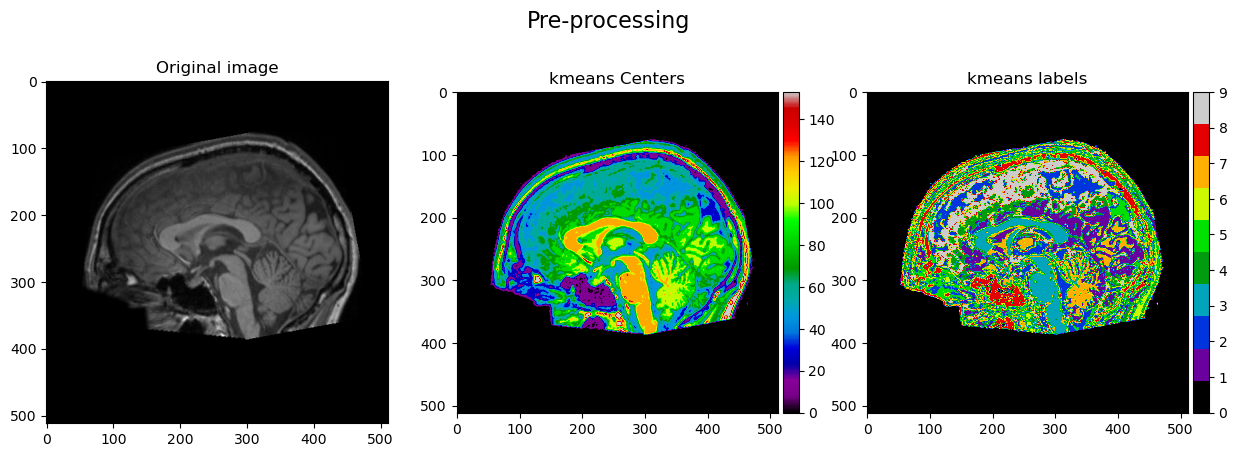

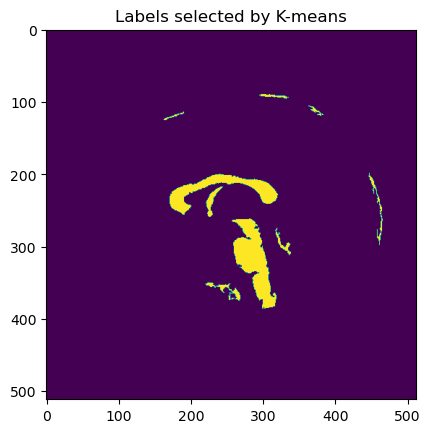


Accuracy of the segmentation : 93.0 %



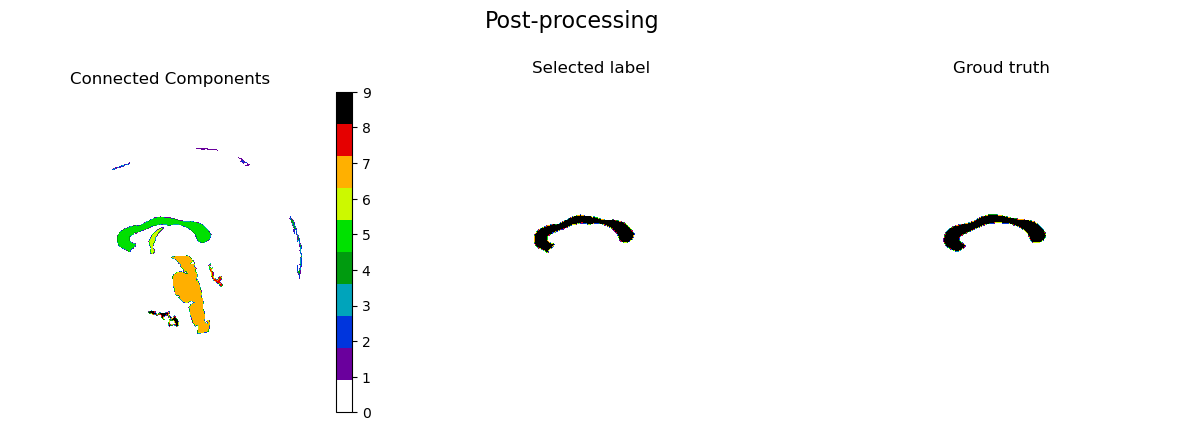

In [18]:
# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10;                 # For abdo image

# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10                 # For cardiac image

Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10;                # For brain image

# Convert to binary mask
Img_seg_gt = np.uint8(Img_seg_gt > 0)

#######################
### Pre-processing  ###
#######################

smoothing = False
opening = False
closing = False

method = 'kmeans'
#method = 'gmm'

if smoothing:
    Img_test = gaussian(Img_test, 2,
                            preserve_range=True)

if opening:
    Radius           = 2
    se               = disk(Radius)
    Img_test  = morpho.opening(Img_test,se)

if closing:
    Radius           = 2
    se               = disk(Radius)
    Img_test_open    = morpho.closing(Img_test,se)


# Segmentation via kmeans
nber_clusters = 10
if method == 'gmm':
    Seg_km,Seg_km_labels = my_gmm(Img_test,nber_clusters)

else:
    Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)

# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(1,3, figsize=(15, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
tmp       = ax[1].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[1])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[1].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')
tmp     = ax[2].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[2])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[2].set_title('kmeans labels')

fig.suptitle('Pre-processing', fontsize=16)

plt.show();

Img_label_means = np.unique(Seg_km)
label_select_means = []
for label_select_mean in target_means:
    distance = np.abs(Img_label_means - label_select_mean)
    idx = np.argmin(distance)
    label_select_means.append(Img_label_means[idx])

Img_label_select = np.isin(Seg_km, label_select_means)

#######################
### Post-processing ###
#######################

Img_label_select_filter = gaussian(Img_label_select, 2,
                            preserve_range=True)
Img_label_select_smooth = Img_label_select>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=50,connectivity=1),
    area_threshold=50)

plt.imshow(Img_label_select_smooth_clean)
plt.title("Labels selected by K-means")
plt.show();


# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output

# Evaluation of the components
evals = []
for label in range(numLabels):
    seg = labels == label
    evals.append(dice(seg, Img_seg_gt))

print()
print(f"Accuracy of the segmentation : {max(evals).round(2) * 100} %")
print()

# Extract the best connected component
thresh = labels==np.argmax(evals)

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(1,3, figsize=(15, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')

ax[2].imshow(Img_seg_gt, cmap=Colormap)
ax[2].set_title('Groud truth')
ax[2].axis('off')

fig.suptitle('Post-processing', fontsize=16)
plt.show();



Segmentation based on K-means is not a robust method and depends on a large number of hyperparameters, but it can be a good method for initialization problems. To improve segmentation results, we can use the Gaussian mixture model instead of K-means, as it uses the assumption that pixels in such a label have a Gaussian distribution and not the 2-norm of the distance like K-means. The fact that the number of pixels is large justifies this assumption.

## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

# Segementing the Cardiac part

# Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.draw import polygon

try:
    import maxflow # if not installed, install Maxflow
except:
    !pip install PyMaxflow # For Google Collab
    import maxflow


## Data exploration

In [20]:
# Read data
MRIheart_path = Working_directory + '/data/MRIheart/'
files_name = os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']
for i in range (11):
    print(f"slice {i} has a {[len(seg[i,j]) for j in range (20)] } landmarks")

slice 0 has a [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] landmarks
slice 1 has a [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] landmarks
slice 2 has a [65, 65, 65, 65, 65, 65, 65, 65, 1, 1, 1, 1, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 3 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 4 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 5 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 6 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 7 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 8 has a [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65] landmarks
slice 9 has a [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] landmarks
slice 10 has a

This data contains 11 slices across 20 time frames. The 11 slices represnet the 3d aspect of the MRI scan and the time dimension caracterises the evolution of the heart over time.

For the segmentation provided we have a set of landmarks for each given slice.
we have two types of segementation : either there is 65 landmarks given or there is none and in the second case the segmentation array will contain only one element = -99999

From what we can see slices 3,4,5,6,7,8 allways contains the organ, slices 0,1 and 10 allways lacks that part and slice 2 has the organ in some time frames and lacks it in others. So the slice 2 will be great for testing our piplne later on. And from now on we will exlude it from every learning process we will conduct.

First, to get a gesture of what we have, we will pick a random time frame and try to see the different aspects of the heart across the slices

### Visualising data

#### Visulaising across slices

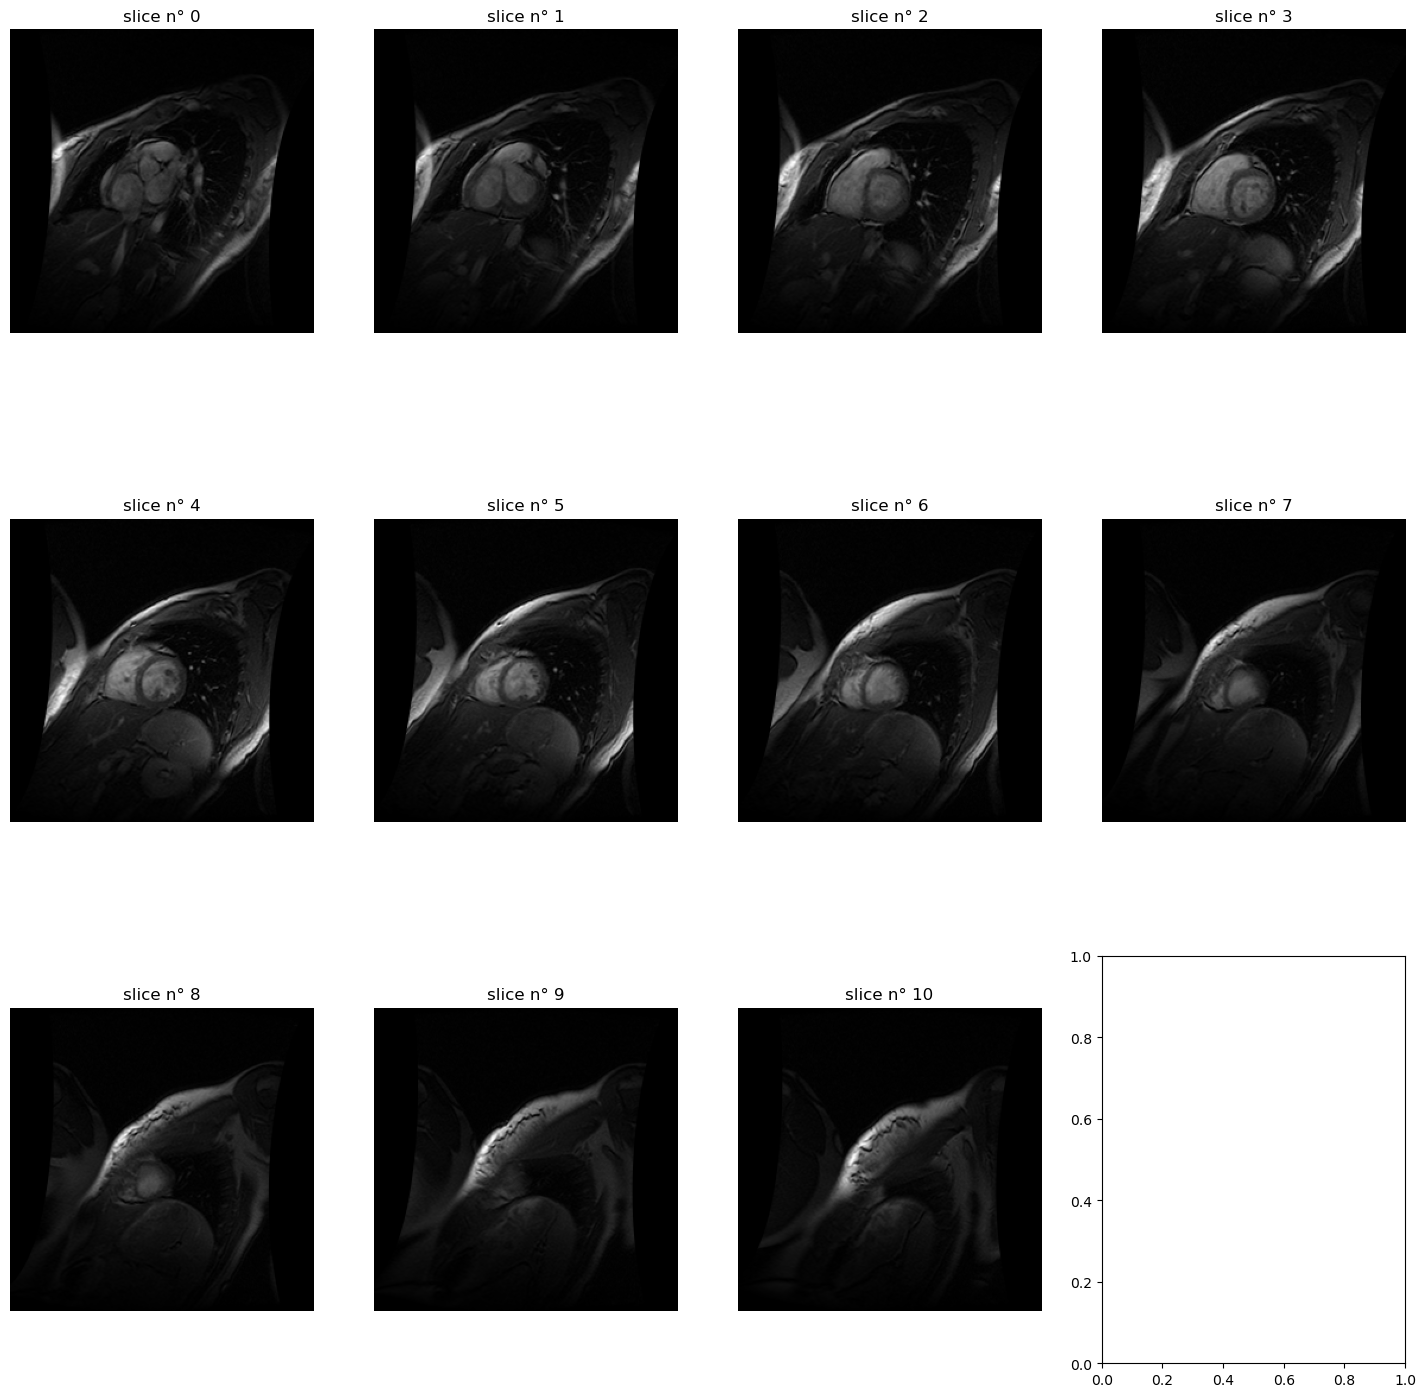

In [21]:
time_index_ex = 16
Img_cardiac_fixed_time = data[:,:,:,time_index_ex]
fig,ax = plt.subplots(3,4,figsize=(18,18))
for i in range(11):
  ax[i//4,i%4].imshow(Img_cardiac_fixed_time[:,:,i],cmap='gray')
  ax[i//4,i%4].axis('off')
  ax[i//4,i%4].set_title(f"slice n° {i}")
plt.show();

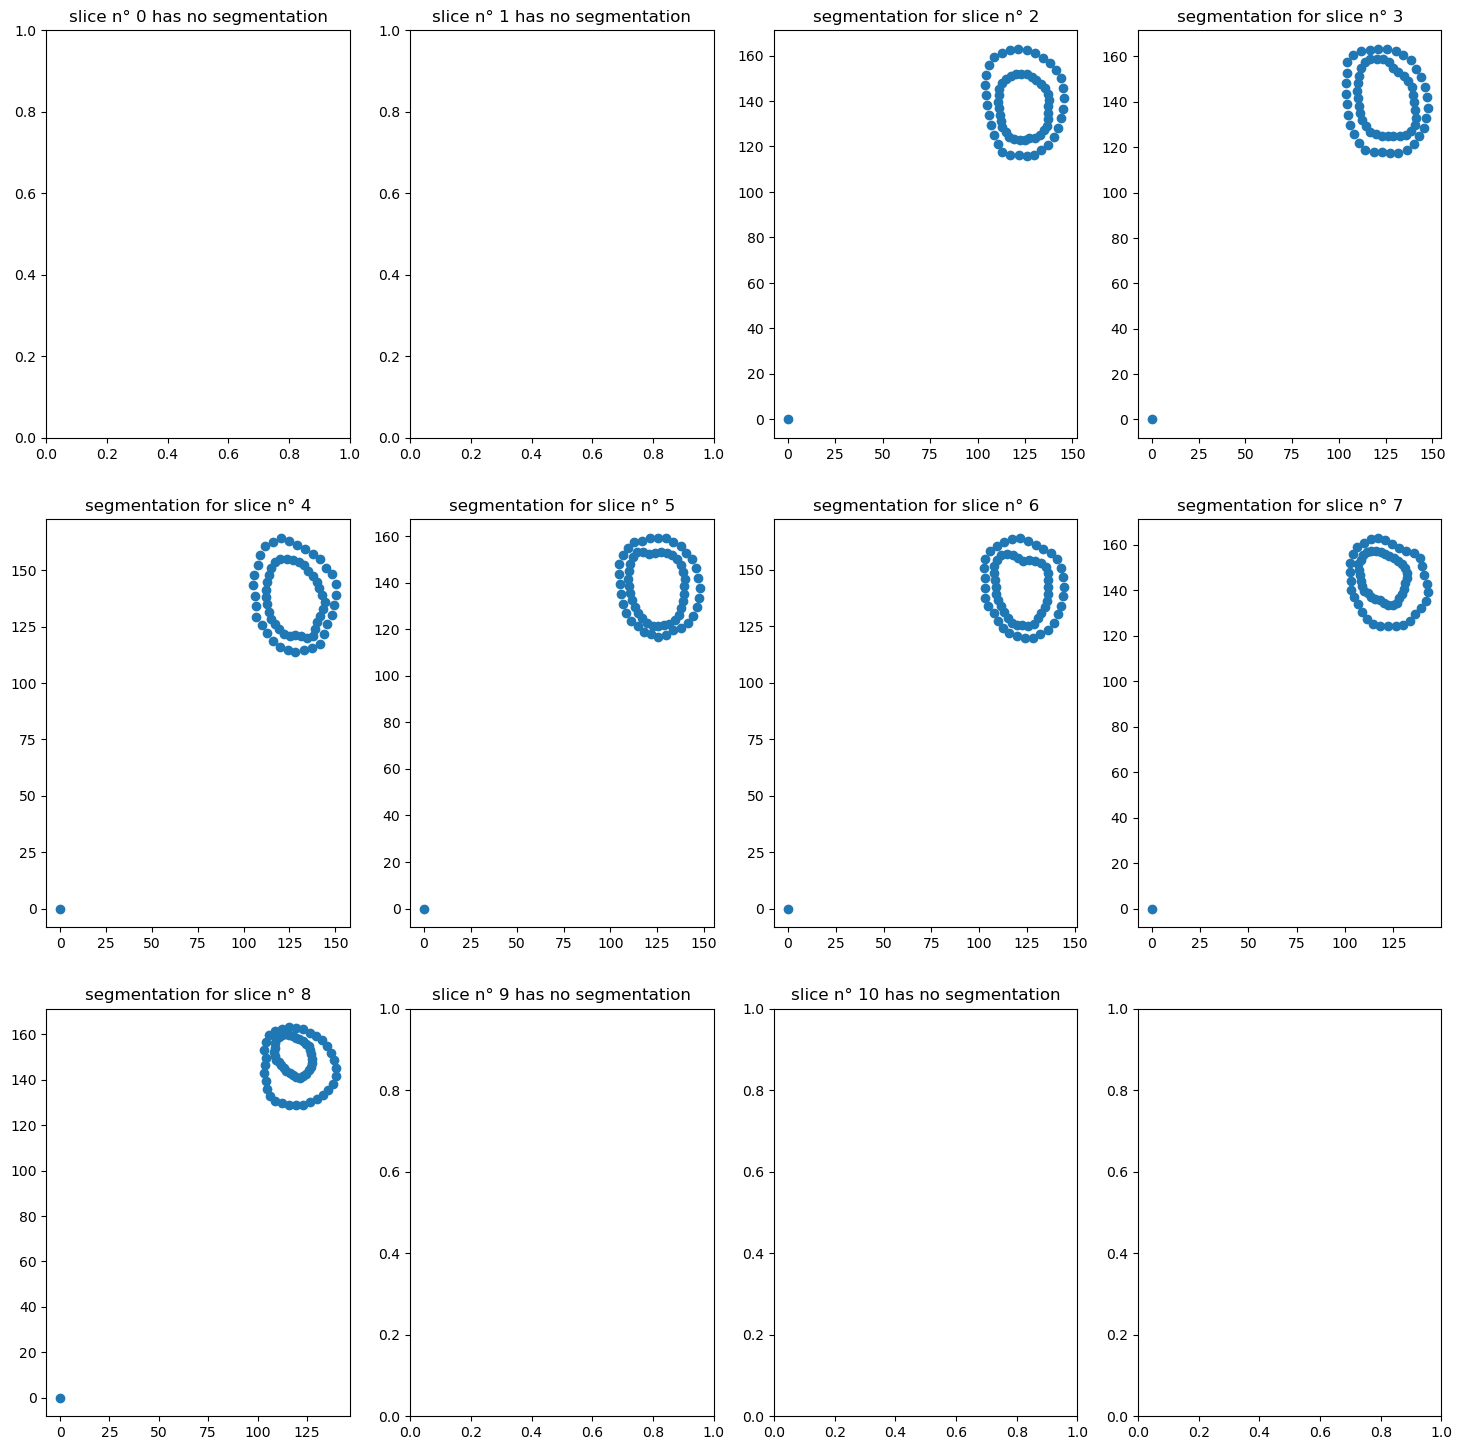

In [22]:
seg_fixed_time = seg[:,time_index_ex]
fig,ax = plt.subplots(3,4,figsize=(18,18))

for i in range(11):
  if(seg_fixed_time[i][0,0]!=-99999):
    ax[i//4,i%4].scatter(seg_fixed_time[i][:,0],seg_fixed_time[i][:,1])
    #seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1)

    ax[i//4,i%4].set_title(f"segmentation for slice n° {i}")
  else :

    ax[i//4,i%4].set_title(f"slice n° {i} has no segmentation")
plt.show();

We see that effectivly not all slices has a segmentation.
The segmentation is almost in the same region no matter what slice we considere. and is approximatly bounded by the box [110:160,100:150]

#### Visualizing across time

throught this example we noitice that not every slice contains the desired organ. In particualr slices n°0 and n°10 doesn't have any pixel that contains the desired part.
Now let's fixed a slice and see the evolution over time of the part

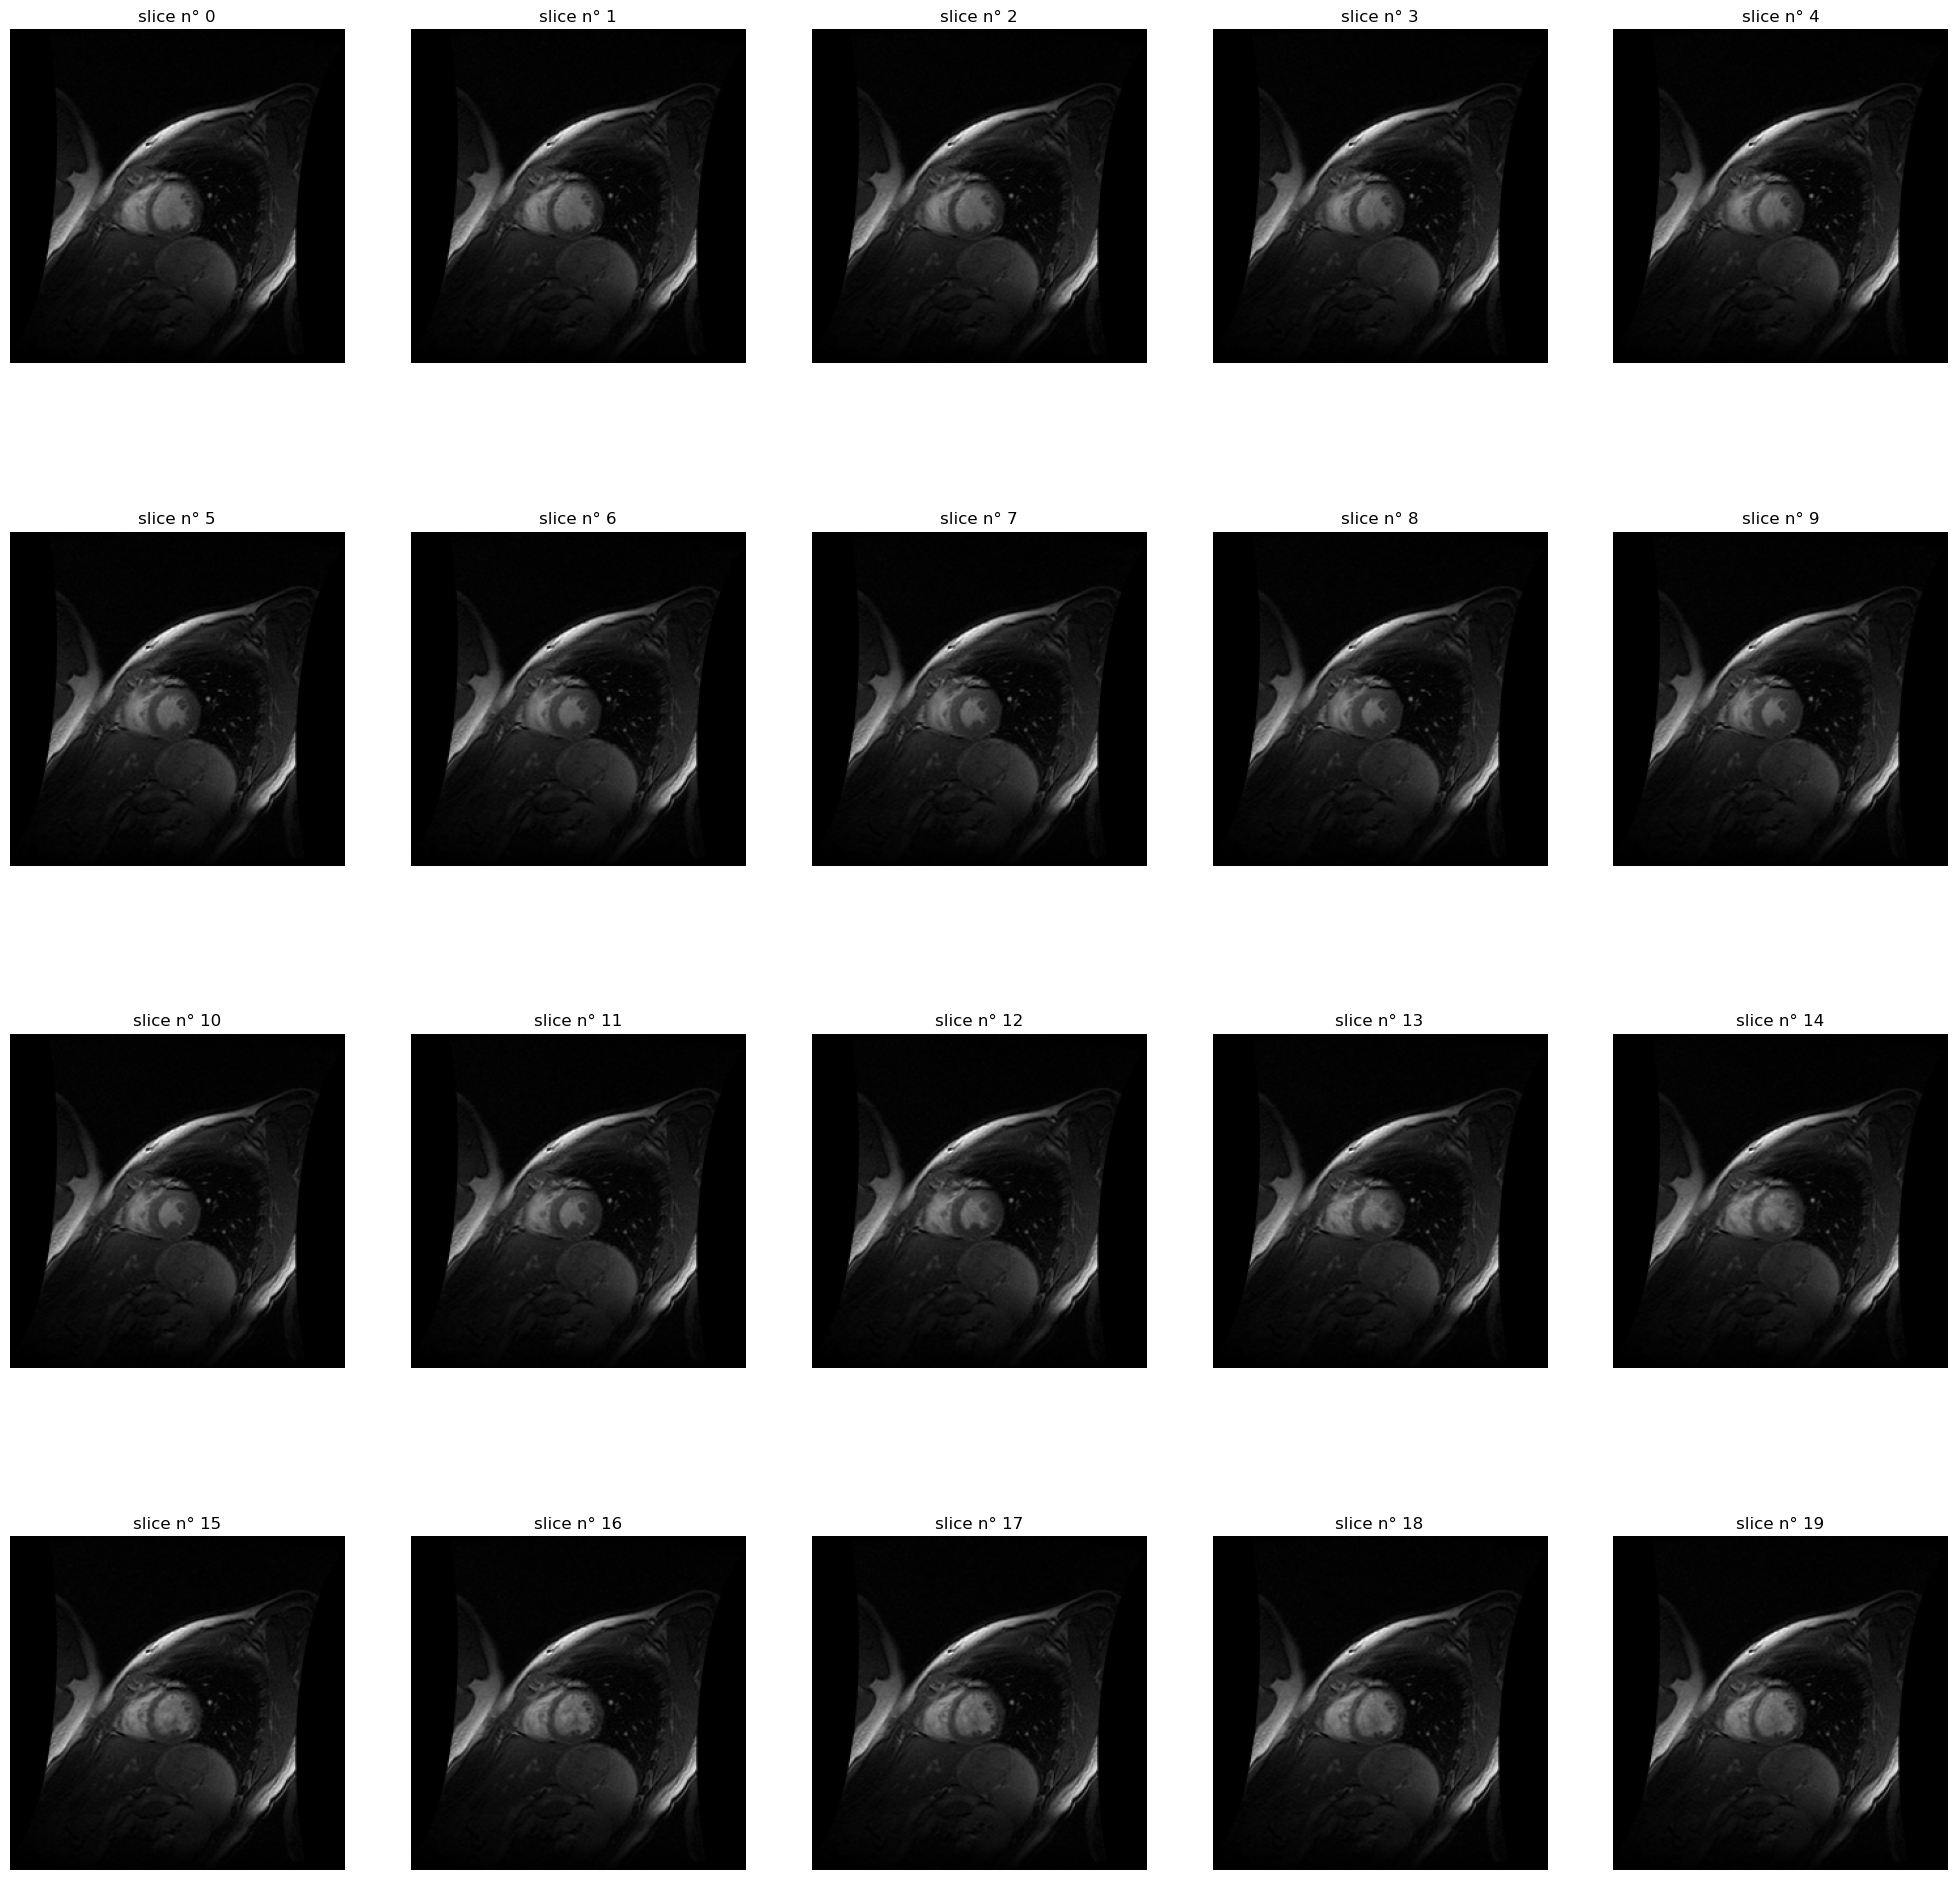

In [23]:
slice_index_ex = 5
Img_cardiac_fixed_slice = data[:,:,slice_index_ex,:]
fig,ax = plt.subplots(4,5,figsize=(25,25))
for i in range(20):
  ax[i//5,i%5].imshow(Img_cardiac_fixed_slice[:,:,i],cmap='gray')
  ax[i//5,i%5].axis('off')
  ax[i//5,i%5].set_title(f"slice n° {i}")
plt.show();

We noitice that the overall structure of the image is still the same. The shape of the desired output varies a little but still keeps the circular shape. However the thickness of the organ may very from time to time especially when comparing the slice n°5 to n°19

In [ ]:
seg_fixed_slice = seg[slice_index_ex,:]
fig,ax = plt.subplots(4,5,figsize=(25,25))
for i in range(20):
  if(seg_fixed_slice[i][0,0]!=-99999):
    ax[i//5,i%5].scatter(seg_fixed_slice[i][:,0],seg_fixed_slice[i][:,1])
    ax[i//5,i%5].set_title(f"slice n° {i}")

  else :
    ax[i//5,i%5].set_title(f"slice n° {i} has no segmentation")
plt.show();

We noitice that the thickness of the part we are considering is changing over time but can be also bounded.

## Hypothesis and summary of the idea of segmentation

After getting a grasp of what kind of data we are dealing with and the part that we want to segment we came up with the following observations:     

-The desired part can be modeled as two coocentric lines. In all the examples that we saw this far, the landmarks can always be presented as two seprate, circular lines and the desired organ is localed between these two lines.

-The desired organ is always located inside a specific area no matter what slice or time we are considering. We can set this area by intuition for now by the bounding box [110:160,100:150] and this can be further inhanced by some statistical shape analysis that we aim to do later on.

-The main idea that we will implement for this pipeline will be the following :     
First, we will conduct a statistical shape analysis in order to extract a mean shape that will serve as an atlas for our segmentation. We will extrat valuable information like the bounding area of the target and intialisation for other algorithms.

Second, we will utilize the active contour algorithm (the snake with balloon forces). We will aim to find the two lines that we talked about. We will set an intial snake inside the area and try to inflate it to segement the lower part then we will set an other snake in the outside and try to deflate it in order to get the outer line. This will enable us to get the segmatation we desire

## Training part :

For the training part we will select slices 3,4,5 across all times and build up the initialization

### Building intializations

In [ ]:
slice_index_list =[3,4,5] # selecting indices for train
data_train = data[:,:,slice_index_list,:].reshape(256,256,-1)
seg_train = seg [slice_index_list,:].reshape(-1)
# elimenate the landmark with (0,0) coordinate which is always indexed 32 in this dataset

for i in range(len(seg_train)) :
  seg_train[i] = np.delete(seg_train[i], 32, axis=0)


In [ ]:
# Example data
data_to_plot =  seg_train[0]

# Scatter plot with indices labeled
plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1])
# Annotate each point with its index
for i, txt in enumerate(range(64)):
    plt.annotate(txt, (data_to_plot[i, 0], data_to_plot[i, 1]))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Indices')
plt.show();

Upon further inspection on the segmentation provided we noitice that the first 32 landmarks correspandes to the line that is inside and the other one is the outter line. This will allow us to induce many properties. First, we will learn the center and the two circles that best fitts all the samples

In [ ]:
X_mean = np.zeros((len(seg_train[0]),2))
for i in range (len(seg_train) ):
    X_mean+=seg_train[i]
X_mean = X_mean/(len(seg_train))
inside_x,inside_y=X_mean[:32,:].mean(axis=0)
outside_x,outside_y = X_mean[32:,:].mean(axis=0)
inside_r,outside_r = 200,0

for i in range (len(seg_train)):
  sample_i = seg_train[i]
  distance_inside = np.min([np.sqrt((inside_x-sample_i[j,0])**2+(inside_y-sample_i[j,1])**2) for j in range(32)])
  inside_r = np.min((inside_r,distance_inside))

  distance_outside = np.max([np.sqrt((outside_x-sample_i[j,0])**2+(outside_y-sample_i[j,1])**2) for j in range(32,64)])
  outside_r = np.max((outside_r,distance_outside))

print(f"learned data : \ncircle_inside (x={inside_x},y={inside_y},r={inside_r})\ncircle_outside (x={outside_x},y={outside_y},r={outside_r})")



In [ ]:
# Plot configurations and first average
plt.figure()
for i in range(0,60):
    landmark=seg_train[i]
    x=landmark[:,0]
    y=landmark[:,1]
    plt.scatter(x, y, c='r')

plt.gca().invert_yaxis()
plt.title('Centered data with first average')


# Example data
data_to_plot =  seg_train[0]

# Scatter plot with indices labeled
plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1])
# Annotate each point with its index
for i, txt in enumerate(range(64)):
    plt.annotate(txt, (data_to_plot[i, 0], data_to_plot[i, 1]))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Indices')


# Create an array of angles from 0 to 2*pi
theta = np.linspace(0, 2*np.pi, 100)

# Parametric equations for a circle
circle_inside_x = inside_x + inside_r * np.cos(theta)
circle_inside_y = inside_y + inside_r * np.sin(theta)

circle_outside_x = outside_x + outside_r * np.cos(theta)
circle_outside_y = outside_y + outside_r * np.sin(theta)


plt.plot(circle_inside_x, circle_inside_y, label='Circle_inside',c="m")

plt.plot(circle_outside_x, circle_outside_y, label='Circle_outside',c="green")

# Mark the center
plt.scatter(inside_x, inside_y, color='m', marker='o', label='Center_inside')

plt.scatter(outside_x, outside_y, color='green', marker='o', label='Center_outside')


# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Circles Plot')
plt.legend()
# Show the plot
plt.grid(True)
plt.show();


In [ ]:
plt.imshow(data_train[:,:,0],cmap="gray")
# Create an array of angles from 0 to 2*pi
theta = np.linspace(0, 2*np.pi, 100)

# Parametric equations for a circle
circle_inside_x = inside_x + inside_r * np.cos(theta)
circle_inside_y = inside_y + inside_r * np.sin(theta)

circle_outside_x = outside_x + outside_r * np.cos(theta)
circle_outside_y = outside_y + outside_r * np.sin(theta)


plt.plot(circle_inside_x, circle_inside_y, label='Circle_inside',c="m")

plt.plot(circle_outside_x, circle_outside_y, label='Circle_outside',c="green")

# Mark the center
plt.scatter(inside_x, inside_y, color='m', marker='o', label='Center_inside')

plt.scatter(outside_x, outside_y, color='green', marker='o', label='Center_outside')


# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Circles Plot')
plt.legend()
# Show the plot
plt.grid(True)
plt.show();

Now as we can see for the whole data set consisting of 5 slices over 20 time frames, the target is always inside the zone delimeted by the two circles. It is safe to assume that the searching area will be that area. Now let's move on to the refinement of these two lines using the deformable models and train the parameters

### Preparing the snake functions and learning the hyperparameters and segmentation

#### Finding the outside line

In [ ]:

# Input image and parameter values
index_selected = 43
img_to_seg   =  data_train[:,:,index_selected];

def define_initial_circle(R0,r0,c0,Nber_pts=400):
      # Define initial contour shape
      s      = np.linspace(0, 2*np.pi, Nber_pts)
      Radius = R0
      r      = r0 + Radius*np.sin(s)
      c      = c0 + Radius*np.cos(s) #col
      init   = np.array([r, c]).T
      return init

def find_outside_snake (img_to_seg,outside_y,outside_x,outside_r,alpha_val=0.01,beta= 0.1,gamma_val = 0.01, convergence_val = 1e-4, Niter_snake = 800) :

  r0 = outside_y;  c0 = outside_x ; R0 = outside_r
  alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
  convergence_val = 1e-4; Niter_snake = 800;

  # Pre smooth the image
  Niter_smooth = 8
  img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

  # Initialise contour
  init = define_initial_circle(R0,r0,c0)

  # Run active contour
  snake30 = active_contour(img_to_seg,
                        init, max_num_iter=30, convergence=convergence_val,
                          alpha=alpha_val, beta=beta_val, gamma=gamma_val)
  snake = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                        alpha=alpha_val, beta=beta_val, gamma=gamma_val)

  return snake

In [ ]:
snake = find_outside_snake (img_to_seg,outside_y,outside_x,outside_r,alpha_val=0.01,beta= 0.1,gamma_val = 0.01, convergence_val = 1e-4, Niter_snake = 800)

init =  define_initial_circle(outside_r,outside_y,outside_x)


# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data_train[:,:,index_selected], cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1,label='intial snake')
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2,label='final snake')
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])
fig.legend()
plt.show();

#### Segementing

In order to find the desired organ we will proceed by a binary classification using a graphcut technique and a prior knowledge on the distrubtion and ising model in order to inforce the fact that we want a continous region

In [ ]:

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(seg_train[index_selected][:, 1], seg_train[index_selected][:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(data_train[:,:,index_selected],cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

We will now limit the part we segment inside the region we got with the snake

In [ ]:
def get_region_to_seg_param (snake):
  x_test,y_test= snake.mean(axis=0)
  r_test = 200.
  for i in range(len(snake)) :
    current_r = np.sqrt((x_test-snake[i][0])**2+(y_test-snake[i][1])**2)
    r_test = np.min((r_test,current_r))
    return x_test,y_test,r_test
x_test,y_test,r_test = get_region_to_seg_param(snake)
print(x_test,y_test,r_test)

Now we study the destribution of the gray levels inside this region. It is clear that the darker region is the one we want.

In [ ]:
#histo desired output :
values_desired = data_train[:,:,index_selected][Seg_cardiac_ex]
mean_desired = values_desired.mean()
var_desired =values_desired.var()
print(f"values_desired average : {mean_desired }, var ={var_desired}")
plt.hist(values_desired,bins = 50);

In [ ]:
def crop_max_value_inside (map,r0,c0,R0):
  ret = np.zeros_like(map)
  for x in range(map.shape [0]) :
    for y in range(map.shape[1]):
      if(((x-c0)**2+(y-r0)**2)<R0**2):
       ret[x,y]=map[x,y]
  return  ret
def get_region_to_seg (img_to_seg,r0,c0,R0):
  ret = np.zeros_like(img_to_seg,dtype=bool)
  for x in range(img_to_seg.shape [0]) :
    for y in range(img_to_seg.shape[1]):
      if(((x-c0)**2+(y-r0)**2)<R0**2):
       ret[x,y]=True
  return ret

In [ ]:
#histo undesired output :

im_mask=get_region_to_seg (img_to_seg,y_test,x_test,r_test)
im_undesired =np.logical_xor(im_mask,Seg_cardiac_ex)
values_undesired = data_train[:,:,0][im_undesired]
mean_undesired = values_undesired.mean()
var_undesired =values_undesired.var()
print(f"undesired value avrg = {mean_undesired} , var =  {var_undesired}")
plt.hist(values_undesired,bins = 50);

In [ ]:
plt.imshow(im_undesired,cmap="gray")

In [ ]:

def segment_binary(img_obs,snake,mean_undesired,mean_desired,var_undesired,var_desired,beta =2100) :

  x_test,y_test,r_test = get_region_to_seg_param(snake)
  im_mask=get_region_to_seg (img_to_seg,y_test,x_test,r_test)

  img_ =img_obs.copy()
  img_[im_mask==False]=(mean_undesired+mean_desired)/2

  m0 =mean_undesired  # m0 and m1 values from the previous practical work
  m1 =mean_desired
  var = (var_desired+var_undesired )/2

  ## binary graph-cut

  # Create the graph.
  g = maxflow.Graph[float]() # Graph instantiation

  # Add the nodes.
  # nodeids has the identifiers of the nodes in the grid.
  # It creates a set of nodes for all the pixels of the image
  nodeids = g.add_grid_nodes(img_.shape)

  # Add non-terminal edges with the same capacity.
  # the edge has the value beta for all adjacent pixels in 4-connexity
  g.add_grid_edges(nodeids, beta)

  # Add the terminal edges.
  # the second argument correspond to the set of edge values to the source
  # the third argument correspond to the set of edge values to the sink
  g.add_grid_tedges(nodeids, (img_-m0)**2, (img_-m1)**2)

  # Find the maximum flow.
  flow = g.maxflow()

  # Get the labels of the nodes in the grid.
  # output is 0 if the node is connected to the source, else output is 1
  sgm = g.get_grid_segments(nodeids)
  im_bin = np.int_(np.logical_not(sgm))
  return im_bin*im_mask

In [ ]:
img_obs = data_train[:,:,index_selected]
my_segmentation = segment_binary(img_obs,snake,mean_undesired,mean_desired,var_undesired,var_desired,beta =10)


In [ ]:
plt.imshow(my_segmentation ,cmap='gray')

### Evaluation on the training set

In [ ]:
def get_mask_from_landmarks(img_to_seg,landmarks):
  Seg_cardiac   = np.zeros_like(img_to_seg, dtype='bool')
  rr, cc = polygon(landmarks[:, 1], landmarks[:, 0], img_to_seg.shape)
  Seg_cardiac[rr, cc] = 1
  return Seg_cardiac
def Dice (img_to_seg,seg,gt_raw):
  gt=get_mask_from_landmarks(img_to_seg,gt_raw)
  intersection = np.sum(gt * seg)
  union = np.sum(gt) + np.sum(seg)

  return  (2.0 * intersection) / (union + 1e-8)

In [ ]:
Dice(img_to_seg,my_segmentation,seg_train[59])

In [ ]:
# selecting examples
indices_to_test = [1,10,15,16,30,40,55,59]
selected_data_train = data_train[:,:,indices_to_test]
selected_seg_train = seg_train[indices_to_test]
my_segs = []
dice_scores =[]
for i in range(len(indices_to_test)):
  img_to_seg = selected_data_train[:,:,i]
  find_outside_snake (img_to_seg,outside_y,outside_x,outside_r,alpha_val=0.01,beta= 0.1,gamma_val = 0.01, convergence_val = 1e-4, Niter_snake = 800)
  my_seg=segment_binary(img_to_seg,snake,mean_undesired,mean_desired,var_undesired,var_desired,beta =10)
  my_segs.append(my_seg)
  dice_scores.append(Dice(img_to_seg,my_seg,selected_seg_train[i]))
print(f"dice_scores obtained is {dice_scores}");


In [ ]:
fig,ax =plt.subplots(len(indices_to_test),3,figsize=(10,16))
for i in range (len(indices_to_test)):
  ax[i,0].imshow(selected_data_train[:,:,i],cmap="gray")
  ax[i,0].set_title("Image to segment")
  ax[i,0].axis("off")

  ax[i,1].imshow(get_mask_from_landmarks(selected_data_train[:,:,i],selected_seg_train[i]),cmap="gray")
  ax[i,1].set_title("Ground truth label")
  ax[i,1].axis("off")

  ax[i,2].imshow(my_segs[i],cmap="gray")
  ax[i,2].set_title(f"My_seg score ={round(dice_scores[i],3)}")
  ax[i,2].axis("off")

plt.show();

# Segmentation and evaluation on the test set :

In [ ]:
#hyperparameters setting aside from the training parameters
outside_y,outside_x,outside_r
#snake paramaeters
alpha_val=0.01;beta= 0.1;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800
# graph_cut param
beta =10
#learned params : a priori knowledge
outside_x_,outside_y_,outside_r_=outside_x,outside_y,outside_r             #125.14152061674174,139.39486063089066,28.889914052532998
mean_undesired_,mean_desired_,var_undesired_,var_desired_ = mean_undesired,mean_desired,var_undesired,var_desired #290.0649496080627,179.55012531328322,6387.375400809331,5210.407888455475


# selecting the second slice to evaluate on
slice_test_index = 2

data_test = data[:,:,slice_index_list,:].reshape(256,256,-1)
seg_test = seg [slice_index_list,:].reshape(-1)

# elimenate the landmark with (0,0) coordinate which is always indexed 32 in this dataset
for i in range(len(seg_test)) :
  if(seg_test[i][0,0]!=-99999):
    seg_test[i] = np.delete(seg_test[i], 32, axis=0)

# selecting 8 time frames to test on
indices_to_test = [i for i in range(12,20)]
selected_data_test = data_test[:,:,indices_to_test]
selected_seg_test = seg_test[indices_to_test]
my_segs = []
dice_scores =[]
for i in range(len(indices_to_test)):
  img_to_seg = selected_data_test[:,:,i]
  snake=find_outside_snake (img_to_seg,outside_y_,outside_x_,outside_r_,alpha_val=0.01,beta= 0.1,gamma_val = 0.01, convergence_val = 1e-4, Niter_snake = 800)
  my_seg=segment_binary(img_to_seg,snake,mean_undesired_,mean_desired_,var_undesired_,var_desired_,beta =10)
  my_segs.append(my_seg)
  dice_scores.append(Dice(img_to_seg,my_seg,selected_seg_train[i]))
print(f"dice_scores obtained is {dice_scores}");


In [ ]:
fig,ax =plt.subplots(len(indices_to_test),3,figsize=(10,16))
for i in range (len(indices_to_test)):
  ax[i,0].imshow(selected_data_test[:,:,i],cmap="gray")
  ax[i,0].set_title("Image to segment")
  ax[i,0].axis("off")

  ax[i,1].imshow(get_mask_from_landmarks(selected_data_test[:,:,i],selected_seg_test[i]),cmap="gray")
  ax[i,1].set_title("Ground truth label")
  ax[i,1].axis("off")

  ax[i,2].imshow(my_segs[i],cmap="gray")
  ax[i,2].set_title(f"My_seg score ={round(dice_scores[i],3)}")
  ax[i,2].axis("off")

plt.show();

## Testing the missing part

This part is particullary challanging because there exists some slices that ressembles heavily the desired segmentation. For example slice 1 frame 1 is particallary hard. because the structure of our hypothesis exists there and verifies all the conditions we set up this far. We can see clearly that the two lines that englobes a certain structure within the bounding box is there  

In [ ]:
seg[1,1]

In [ ]:
plt.imshow(data[:,:,1,1],cmap="gray")